As before, I read in the tidy dataframe with clean values from a pickled file, using the "read_pickle()" method and show its structure:

In [1]:
import pandas as pd
df = pd.read_pickle('EU_industry_production_dataframe_clean.pkl')
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27936 entries, (1953-01-01 00:00:00, AT) to (2017-08-01 00:00:00, UK)
Data columns (total 2 columns):
production_index    8744 non-null float64
flags               27936 non-null category
dtypes: category(1), float64(1)
memory usage: 333.9+ KB
                         production_index flags
time       country_code                        
1953-01-01 AT                         NaN      
           BA                         NaN      
           BE                         NaN      
           BG                         NaN      
           CY                         NaN      


From the exploratory data analysis that I did in the previous project I know that the individual countries showed a sudden drop in the production index values in 2008. Here is how I plotted the curves for all the countries:

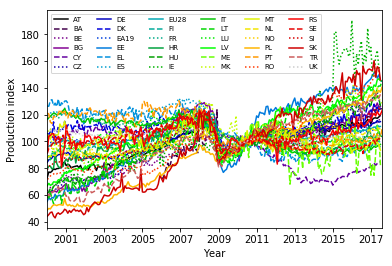

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Select data for years 2000-2017 and store it in a new dataframe:
df_late = df.loc[(slice('2000','2017'),slice(None)),:].copy()   # Note: the copy() is needed to avoid getting a view

# Create figure and axes objects:
fig, ax = plt.subplots()

# Reset line properties to avoid ambiguity between different lines:
ax.set_prop_cycle(color=plt.cm.nipy_spectral(np.linspace(0,1,36)),linestyle=['-','--',':']*12)

# Create the plot:
ax = df_late.unstack(level=1).plot(y='production_index',ax=ax)
plt.xlabel('Year')
plt.ylabel('Production index')
ax.legend(ncol=6, fontsize=7)   # Adjust shape (four columns instead of one) and font size of legend
plt.show()

The drop is clearest in the average over all 28 EU countries:

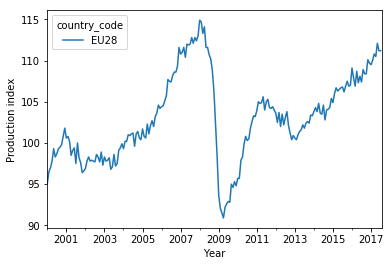

In [3]:
eu_avg_late = df_late.loc[(slice(None),'EU28'),:].unstack(level=1)  # Select EU average for years 2000-2017

ax = eu_avg_late.plot(y='production_index')  # Plot
plt.xlabel('Year')
plt.ylabel('Production index')
plt.show()

This curve can be used to normalize the time series for each country, to bring out the individual long-term trends.

Before doing this, I first smooth the EU average to get rid of the short-time fluctuations. There are different ways to accomplish this (e.g., Savitzky-Golay filters), with different side effects. Here, I just want a rough correction and use a simple rolling mean over five consecutive time steps (five months):

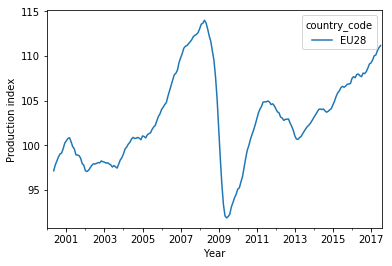

In [4]:
eu_avg_late_smooth = eu_avg_late.rolling(window=5).mean()  # Smooth EU average

ax = eu_avg_late_smooth.plot(y='production_index')  # Plot
plt.xlabel('Year')
plt.ylabel('Production index')
plt.show()

This curve is smoother indeed. Note, however, that I lose four data points at the beginning (January 2000 through April 2000) because the rolling mean of five points needs the current point plus the previous four data points to output a value.

To prevent this from happening, I first apply the rolling mean on the full time series first and only then select the period 2000--2017:

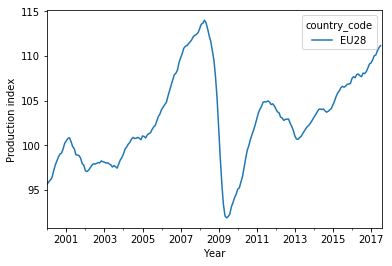

In [5]:
eu_avg = df.loc[(slice(None),'EU28'),:].unstack(level=1)  # Select EU average for all years (1953-2017)
eu_avg_smooth = eu_avg.rolling(window=5).mean()           # Smooth EU average
eu_avg_late_smooth_corrected = eu_avg_smooth.loc[slice('2000','2017'),:]  # Restrict to years 2000-2017

ax = eu_avg_late_smooth_corrected.plot(y='production_index')  # Plot
plt.xlabel('Year')
plt.ylabel('Production index')
plt.show()

Now I take the smoothed curve and divide each time series in "df_late" by it, element-wise. This is done with the pandas "div()" method. Before applying it, I select the "production_index" (since I cannot sensibly divide the flag strings by numbers) and unstack the "country_code" from the MultiIndex (turn each country into its own column).

In the resulting pandas series, I stack up the "country_code" values in the index again to have the same structure as in the original dataframe:

In [6]:
eu_avg_late_smooth_corrected_series = eu_avg_late_smooth_corrected['production_index','EU28']  # Select pandas series

# Unstack country_code, divide each column by smoothed series, stack country_code again:
production_index_norm_series = df_late['production_index'].unstack(level=1).div(eu_avg_late_smooth_corrected_series,axis=0).stack()
print(production_index_norm_series.head())

time        country_code
2000-01-01  AT              0.763119
            BE              0.659628
            BG              0.638720
            CY              1.076730
            CZ              0.609450
dtype: float64


This series contains the ratio of a country's production index and the EU average production index, so it is easy to see how well a country has performed compared to others in the given period.

Let's plot the curves and see if the dip after the start of the financial crisis is gone:

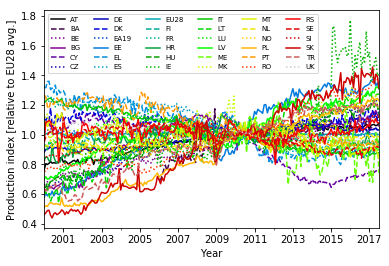

In [7]:
fig, ax = plt.subplots()        # Create figure and axes objects

# Reset line properties to avoid ambiguity between different lines:
ax.set_prop_cycle(color=plt.cm.nipy_spectral(np.linspace(0,1,36)),linestyle=['-','--',':']*12)

# Create the plot:
ax = production_index_norm_series.unstack(level=1).plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('Production index [relative to EU28 avg.]')
ax.legend(ncol=6, fontsize=7)   # Adjust shape (four columns instead of one) and font size of legend
plt.show()

The correction is far from perfect, but removes the biggest part of the dip in the years 2008--2011. 

I integrate the normalized industry production values into the dataframe:

In [10]:
df_late.loc[:,'production_index_norm'] = production_index_norm_series
print(df_late.info())
print(df_late.head())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7632 entries, (2000-01-01 00:00:00, AT) to (2017-08-01 00:00:00, UK)
Data columns (total 3 columns):
production_index         7412 non-null float64
flags                    7632 non-null category
production_index_norm    7404 non-null float64
dtypes: category(1), float64(2)
memory usage: 156.8+ KB
None
                         production_index flags  production_index_norm
time       country_code                                               
2000-01-01 AT                        73.0                     0.763119
           BA                         NaN                          NaN
           BE                        63.1                     0.659628
           BG                        61.1                     0.638720
           CY                       103.0                     1.076730


I store this dataframe on disk:

In [11]:
df_late.to_pickle('EU_industry_production_dataframe_normalized_2000-2017.pkl')